In [ ]:
!pip install torch torchvision nump pandas scikit-learn transformers wandb

In [ ]:
import torch
print(torch.__version__)

2.5.1+cu121


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

df = pd.read_csv('https://archive.org/download/fine-tune-bert-tensorflow-train.csv/train.csv.zip',
                 compression = 'zip', low_memory = False)
df.shape

(1306122, 3)

In [ ]:
df.shape

(1306122, 3)

In [ ]:
df.tail(20)

,qid,question_text,target
1306102,ffff3778790af9baae76,What steps can I take to live a normal life if...,0
1306103,ffff3f0a2449ffe4b9ff,Isn't Trump right after all? Why should the US...,1
1306104,ffff41393389d4206066,Is 33 too late for a career in creative advert...,0
1306105,ffff42493fc203cd9532,What is difference between the filteration wor...,0
1306106,ffff48dd47bee89fff79,"If the universe ""popped"" into existence from n...",0
1306107,ffff5fd051a032f32a39,How does a shared service technology team meas...,0
1306108,ffff6d528040d3888b93,How is DSATM civil engineering?,0
1306109,ffff8776cd30cdc8d7f8,Do you know any problem that depends solely on...,0
1306110,ffff94d427ade3716cd1,What are some comic ideas for you Tube videos ...,0
1306111,ffffa382c58368071dc9,"If you had $10 million of Bitcoin, could you s...",0


In [ ]:
df = df[df['question_text'].str.len() <= 64]

In [ ]:
df.shape

(728490, 3)

In [ ]:
# Separate data for each class
# Most data are labeled 0
class_0 = df[df['target'] == 0]
class_1 = df[df['target'] == 1]

class_0 = class_0.sample(n=600000, random_state=42)
class_1 = class_1.sample(n=10000, random_state=42)

df = pd.concat([class_0, class_1], axis=0)
df = df.sample(frac=1).reset_index(drop=True)
class_0.shape, class_1.shape, df.shape

((600000, 3), (10000, 3), (610000, 3))

<Axes: title={'center': 'Target Distribution'}, ylabel='Frequency'>

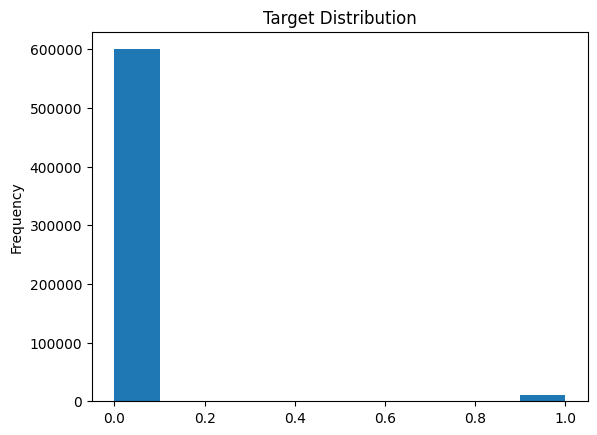

In [ ]:
# target label distribution
df.target.plot(kind='hist', title="Target Distribution")

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
sentence_0 = class_0.question_text.values
labels_0  = class_0.target.values
sentence_1 = class_1.question_text.values
labels_1  = class_1.target.values

In [ ]:
import torch
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids_0 = []
attention_masks_0 = []

input_ids_1 = []
attention_masks_1 = []

# For every sentence...
def tokenize_sentences(sentences,labels,input_ids,attention_masks):
  for sent in sentences:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sent,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 64,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )

      # Add the encoded sentence to the list.
      input_ids.append(encoded_dict['input_ids'])

      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])

  # Convert the lists into tensors.
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)

  # Print sentence 0, now as a list of IDs.
  print('Original: ', sentences[0])
  print('Token IDs:', input_ids[0])
  return input_ids,attention_masks,labels

# Process two data group
input_ids_0, attention_masks_0, labels_0 = tokenize_sentences(sentence_0,labels_0,input_ids_0,attention_masks_0)
input_ids_1, attention_masks_1, labels_1 = tokenize_sentences(sentence_1,labels_1,input_ids_1,attention_masks_1)

print("=====================OUTSIDE==================")
print('This is my input',type(input_ids_0))
print('This is my attention_mask',type(attention_masks_0))
print('This is my labels', type(labels_0))
print('This is my input',type(input_ids_1))
print('This is my attention_mask',type(attention_masks_1))
print('This is my labels', type(labels_1))

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2834: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  Can a cat die due to infection?
Token IDs: tensor([ 101, 2064, 1037, 4937, 3280, 2349, 2000, 8985, 1029,  102,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])
Original:  Are Israelis easily get angry?
Token IDs: tensor([  101,  2024, 28363,  4089,  2131,  4854,  1029,   102,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,

In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset_0 = TensorDataset(input_ids_0, attention_masks_0, labels_0)
dataset_1 = TensorDataset(input_ids_1, attention_masks_1, labels_1)


# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset_0))
val_size = len(dataset_0) - train_size

train_size_1 = int(0.9 * len(dataset_1))
val_size_1 = len(dataset_1) - train_size_1

# Divide the dataset by randomly selecting samples.
train_dataset_0, val_datase_0 = random_split(dataset_0, [train_size, val_size])
train_dataset_1, val_datase_1 = random_split(dataset_1, [train_size_1, val_size_1])

train_dataset = torch.utils.data.ConcatDataset([train_dataset_0, train_dataset_1])
val_dataset = torch.utils.data.ConcatDataset([val_datase_0, val_datase_1])

print('{:>5,} training samples'.format(len(train_dataset)))
print('{:>5,} validation samples'.format(val_size))

549,000 training samples
60,000 validation samples


In [ ]:
# # Example: Analyze tokenized sequence lengths
# sequence_lengths = [len(tokenizer(text)['input_ids']) for text in df['question_text']]
# import matplotlib.pyplot as plt

# plt.hist(sequence_lengths, bins=50)
# plt.title("Sequence Length Distribution")
# plt.xlabel("Sequence Length")
# plt.ylabel("Frequency")
# plt.show()


In [ ]:
import wandb
# sweep_config = {
#     'method': 'random', #grid, random
#     'metric': {
#       'name': 'val_accuracy',
#       'goal': 'maximize'
#     },
#     'parameters': {

#         'learning_rate': {
#             'values': [ 5e-5, 3e-5, 2e-5]
#         },
#         'batch_size': {
#             'values': [16, 32]
#         },
#         'epochs':{
#             'values':[2, 3, 4]
#         }
#     }
# }

sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'val_accuracy',
      'goal': 'maximize'
    },
    'parameters': {

        'learning_rate': {
            'values': [8e-5]
        },
        'batch_size': {
            'values': [256]
        },
        'epochs':{
            'values':[2]
        }
    }
}
sweep_defaults = {
            'learning_rate': 5e-5,

        'batch_size': 32,

        'epochs':2
}

sweep_id = wandb.sweep(sweep_config)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Create sweep with ID: 0ibhtxti
Sweep URL: https://wandb.ai/zhumoore9661996-johns-hopkins-university/uncategorized/sweeps/0ibhtxti


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import wandb
# WANDB PARAMETER
def ret_dataloader():
    batch_size = wandb.config.batch_size
    print('batch_size = ', batch_size)
    train_dataloader = DataLoader(
                train_dataset,  # The training samples.
                sampler = RandomSampler(train_dataset), # Select batches randomly
                batch_size = batch_size # Trains with this batch size.
            )

    validation_dataloader = DataLoader(
                val_dataset, # The validation samples.
                sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
                batch_size = batch_size # Evaluate with this batch size.
            )
    return train_dataloader,validation_dataloader

# Load Pre-trained BERT model

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

def ret_model():

    model = BertForSequenceClassification.from_pretrained(
        "bert-base-uncased",
        num_labels = 2,
        hidden_dropout_prob=0.3,  # Set dropout rate for fully connected layers
        attention_probs_dropout_prob=0.3,  # Set dropout rate for attention weights
        output_attentions = False, # Whether the model returns attentions weights.
        output_hidden_states = False, # Whether the model returns all hidden-states.
    )

    return model


In [ ]:
def ret_optim(model):
    print('Learning_rate = ',wandb.config.learning_rate )
    optimizer = torch.optim.AdamW(model.parameters(),lr = wandb.config.learning_rate, weight_decay=0.01)
    return optimizer


In [ ]:
from transformers import get_linear_schedule_with_warmup

def ret_scheduler(train_dataloader,optimizer):
    epochs = wandb.config.epochs
    print('epochs =>', epochs)
    # Total number of training steps is [number of batches] x [number of epochs].
    # (Note that this is not the same as the number of training samples).
    total_steps = len(train_dataloader) * epochs

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(optimizer,
                                                num_warmup_steps = 0, # Default value in run_glue.py
                                                num_training_steps = total_steps)
    return scheduler

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
# torch.multiprocessing.set_start_method('spawn', force=True)

In [ ]:
import random
import numpy as np

    # This training code is based on the `run_glue.py` script here:
    # https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

    # Set the seed value all over the place to make this reproducible.
def train():
    wandb.init()
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(device)
    model = ret_model()
    model.to(device)
    #wandb.init(config=sweep_defaults)
    train_dataloader,validation_dataloader = ret_dataloader()
    optimizer = ret_optim(model)
    scheduler = ret_scheduler(train_dataloader,optimizer)

    #print("config ",wandb.config.learning_rate, "\n",wandb.config)
    seed_val = 42

    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    #torch.cuda.manual_seed_all(seed_val)

    # We'll store a number of quantities such as training and validation loss,
    # validation accuracy, and timings.
    training_stats = []

    # Measure the total training time for the whole run.
    total_t0 = time.time()
    epochs = wandb.config.epochs
    # For each epoch...
    for epoch_i in range(0, epochs):

        # ========================================
        #               Training
        # ========================================

        # Perform one full pass over the training set.

        print("")
        print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
        print('Training...')

        # Measure how long the training epoch takes.
        t0 = time.time()

        # Reset the total loss for this epoch.
        total_train_loss = 0

        # Put the model into training mode. Don't be mislead--the call to
        # `train` just changes the *mode*, it doesn't *perform* the training.
        # `dropout` and `batchnorm` layers behave differently during training
        # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):

            # Progress update every 40 batches.
            if step % 40 == 0 and not step == 0:
                # Calculate elapsed time in minutes.
                elapsed = format_time(time.time() - t0)

                # Report progress.
                print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

            # Unpack this training batch from our dataloader.
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using the
            # `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids
            #   [1]: attention masks
            #   [2]: labels
            b_input_ids = batch[0].to(device)
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Always clear any previously calculated gradients before performing a
            # backward pass. PyTorch doesn't do this automatically because
            # accumulating the gradients is "convenient while training RNNs".
            # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
            model.zero_grad()

            # Perform a forward pass (evaluate the model on this training batch).
            # The documentation for this `model` function is here:
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # It returns different numbers of parameters depending on what arguments
            # arge given and what flags are set. For our useage here, it returns
            # the loss (because we provided labels) and the "logits"--the model
            # outputs prior to activation.
            # loss, logits = model(b_input_ids,
            #                     token_type_ids=None,
            #                     attention_mask=b_input_mask,
            #                     labels=b_labels)
            outputs = model(b_input_ids,
                                token_type_ids=None,
                                attention_mask=b_input_mask,
                                labels=b_labels)
            #Log the train loss
            #Extract loss and logits
            loss = outputs.loss
            logits = outputs.logits
            # wandb.log({'train_batch_loss':loss.item()})
            wandb.log({'train_batch_loss':loss.item()})

            # Accumulate the training loss over all of the batches so that we can
            # calculate the average loss at the end. `loss` is a Tensor containing a
            # single value; the `.item()` function just returns the Python value
            # from the tensor.
            total_train_loss += loss.item()

            # Perform a backward pass to calculate the gradients.
            loss.backward()

            # Clip the norm of the gradients to 1.0.
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and take a step using the computed gradient.
            # The optimizer dictates the "update rule"--how the parameters are
            # modified based on their gradients, the learning rate, etc.
            optimizer.step()

            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over all of the batches.
        avg_train_loss = total_train_loss / len(train_dataloader)

        # Measure how long this epoch took.
        training_time = format_time(time.time() - t0)

        wandb.log({'avg_train_loss':avg_train_loss})

        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))
        print("  Training epcoh took: {:}".format(training_time))

        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        print("")
        print("Running Validation...")

        t0 = time.time()

        # Put the model in evaluation mode--the dropout layers behave differently
        # during evaluation.
        model.eval()

        # Tracking variables
        total_eval_accuracy = 0
        total_eval_loss = 0
        nb_eval_steps = 0

        # Evaluate data for one epoch
        for batch in validation_dataloader:

            # Unpack this training batch from our dataloader.
            #
            # As we unpack the batch, we'll also copy each tensor to the GPU using
            # the `to` method.
            #
            # `batch` contains three pytorch tensors:
            #   [0]: input ids
            #   [1]: attention masks
            #   [2]: labels
            b_input_ids = batch[0].cuda()
            b_input_mask = batch[1].to(device)
            b_labels = batch[2].to(device)

            # Tell pytorch not to bother with constructing the compute graph during
            # the forward pass, since this is only needed for backprop (training).
            with torch.no_grad():

                # Forward pass, calculate logit predictions.
                # token_type_ids is the same as the "segment ids", which
                # differentiates sentence 1 and 2 in 2-sentence tasks.
                # The documentation for this `model` function is here:
                # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
                # Get the "logits" output by the model. The "logits" are the output
                # values prior to applying an activation function like the softmax.
                outputs = model(b_input_ids,
                                      token_type_ids=None,
                                      attention_mask=b_input_mask,
                                      labels=b_labels)

            # Accumulate the validation loss.
            loss = outputs.loss
            logits = outputs.logits

            total_eval_loss += loss.item()

            # Move logits and labels to CPU
            logits = logits.detach().cpu().numpy()
            label_ids = b_labels.to('cpu').numpy()

            # Calculate the accuracy for this batch of test sentences, and
            # accumulate it over all batches.
            total_eval_accuracy += flat_accuracy(logits, label_ids)


        # Report the final accuracy for this validation run.
        avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
        print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(validation_dataloader)

        # Measure how long the validation run took.
        validation_time = format_time(time.time() - t0)
        wandb.log({'val_accuracy':avg_val_accuracy,'avg_val_loss':avg_val_loss})
        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        print("  Validation took: {:}".format(validation_time))

        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch_i + 1,
                'Training Loss': avg_train_loss,
                'Valid. Loss': avg_val_loss,
                'Valid. Accur.': avg_val_accuracy,
                'Training Time': training_time,
                'Validation Time': validation_time
            }
        )

    print("")
    print("Training complete!")

    print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

In [ ]:
wandb.agent(sweep_id,function=train)

wandb: Agent Starting Run: 29xofagf with config:
wandb: 	batch_size: 256
wandb: 	epochs: 2
wandb: 	learning_rate: 8e-05
wandb: Currently logged in as: zhumoore9661996 (zhumoore9661996-johns-hopkins-university). Use `wandb login --relogin` to force relogin


cuda


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


batch_size =  256
Learning_rate =  8e-05
epochs => 2

======== Epoch 1 / 2 ========
Training...
  Batch    40  of  2,145.    Elapsed: 0:00:40.
  Batch    80  of  2,145.    Elapsed: 0:01:20.
  Batch   120  of  2,145.    Elapsed: 0:02:02.
  Batch   160  of  2,145.    Elapsed: 0:02:42.
  Batch   200  of  2,145.    Elapsed: 0:03:23.
  Batch   240  of  2,145.    Elapsed: 0:04:04.
  Batch   280  of  2,145.    Elapsed: 0:04:45.
  Batch   320  of  2,145.    Elapsed: 0:05:25.
  Batch   360  of  2,145.    Elapsed: 0:06:06.
  Batch   400  of  2,145.    Elapsed: 0:06:47.
  Batch   440  of  2,145.    Elapsed: 0:07:28.
  Batch   480  of  2,145.    Elapsed: 0:08:09.
  Batch   520  of  2,145.    Elapsed: 0:08:50.
  Batch   560  of  2,145.    Elapsed: 0:09:30.
  Batch   600  of  2,145.    Elapsed: 0:10:11.
  Batch   640  of  2,145.    Elapsed: 0:10:52.
  Batch   680  of  2,145.    Elapsed: 0:11:33.
  Batch   720  of  2,145.    Elapsed: 0:12:13.
  Batch   760  of  2,145.    Elapsed: 0:12:54.
  Batch   8

wandb: Ctrl + C detected. Stopping sweep.
